In [31]:
import requests
from urllib.request import urlopen
from io import StringIO
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pyproj import CRS, Transformer
import json

# Data Collection

In [32]:
# fetch data set
req = requests.get(
    "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
)

# # write data to csv file
# csv_file = open("fahrraddiebstaehle.csv", "w", encoding="utf-8")
# csv_file.write(req.text)
# csv_file.close()

# load data to pandas df
df = pd.read_csv(StringIO(req.text), delimiter=",", dtype={"LOR": object})


In [33]:
response = urlopen("https://raw.githubusercontent.com/JJestel/HCDS/main/a1/data/lor.csv?token=GHSAT0AAAAAACB3GOVE4JPZ6IE5DCEGW7BMZCUEGLA")
lor = pd.read_csv(response, delimiter=";", dtype=object)

response = urlopen("https://raw.githubusercontent.com/JJestel/HCDS/main/a1/data/einwohnerbestand_06-2022_plr.csv?token=GHSAT0AAAAAACB3GOVEFMB4BV25IN52VIUGZCUD6QA")
ew = pd.read_csv(response, delimiter=";", dtype={"PLR-ID": object})

In [34]:
r = requests.get("https://tsb-opendata.s3.eu-central-1.amazonaws.com/lor_planungsgraeume_2021/lor_planungsraeume_2021.geojson")
geojson = json.loads(r.content)

# Data Processing

In [35]:
df['TATZEIT_ANFANG'] = pd.to_datetime(df['TATZEIT_ANFANG_DATUM'].astype(str) + ' ' + df['TATZEIT_ANFANG_STUNDE'].astype(str) + ':00:00', dayfirst=True)
df['TATZEIT_ENDE'] = pd.to_datetime(df['TATZEIT_ENDE_DATUM'].astype(str) + ' ' + df['TATZEIT_ENDE_STUNDE'].astype(str) + ':00:00', dayfirst=True)
df = df.drop(columns=['TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE', 'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE'])
df['ANGELEGT_AM'] = pd.to_datetime(df['ANGELEGT_AM'], dayfirst=True)
df

,ANGELEGT_AM,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,TATZEIT_ANFANG,TATZEIT_ENDE
0,2023-05-03,01300836,600,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-02 20:00:00,2023-05-02 20:00:00
1,2023-05-03,04501040,1750,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-04-27 23:00:00,2023-04-28 09:00:00
2,2023-05-03,04400832,849,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-02 20:00:00,2023-05-03 06:00:00
3,2023-05-03,06400737,699,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-05-02 08:00:00,2023-05-02 13:00:00
4,2023-05-03,04400835,3350,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2023-04-30 18:00:00,2023-05-02 19:00:00
...,...,...,...,...,...,...,...,...,...
28414,2022-01-02,07200413,660,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-01-02 08:00:00,2022-01-02 17:00:00
28415,2022-01-01,01300730,150,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-01-01 20:00:00,2022-01-01 20:00:00
28416,2022-01-01,02100106,190,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-01-01 04:00:00,2022-01-01 08:00:00
28417,2022-01-01,03601142,1000,Nein,Herrenfahrrad,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-01-01 14:00:00,2022-01-01 14:00:00


In [37]:
lor = lor.merge(ew, left_on='Planungsraum (Nummer)', right_on='PLR-ID')
lor = lor.drop(columns= ['techn. Schlüssel (UUID)', 'Stand der Daten', 'ausländer', 'PLR-ID', 'weiblich'])
lor["Fläche in qm"] = lor["Fläche in qm"].str.replace(",", ".").astype(float)
int_cols = ['Gesamt', 'unter6', '6-15', '15-18', '18-27', '27-45','45-55', '55-65', '65undmehr']
lor[int_cols] = lor[int_cols].replace('–', -1).astype(int)

In [39]:
# transform coordinate reference system
transformer = Transformer.from_crs(25833, 4326)

geojson['crs']['properties']['name'] = "urn:ogc:def:crs:EPSG::4326"

for i in range(len(geojson['features'])):
    for j, el in enumerate(geojson['features'][i]['geometry']['coordinates'][0][0]):
        x, y = transformer.transform(*el)
        geojson['features'][i]['geometry']['coordinates'][0][0][j][0] = y
        geojson['features'][i]['geometry']['coordinates'][0][0][j][1] = x


# Data Analysis

### Where are the most bikes stolen?


In [40]:
# aggregate thefts per Planungsraum
temp = df.groupby(by="LOR").size().to_frame().rename(columns={0: "Diebstaehle"})
lor = lor.merge(temp, left_on="Planungsraum (Nummer)", right_index=True, how="left")
lor['Diebstaehle'] = lor['Diebstaehle'].fillna(0).astype(int)
lor.sort_values(by='Diebstaehle', ascending=False).head(10)

,Planungsraum (Nummer),Planungsraum (Name),Bezirksregion (Nummer),Bezirksregion (Name),Prognoseraum (Nummer),Prognoseraum (Name),Bezirk,Fläche in qm,Gesamt,unter6,6-15,15-18,18-27,27-45,45-55,55-65,65undmehr,Diebstaehle
381,09100101,Alt-Treptow,091001,Alt-Treptow,0910,Treptow-Köpenick 1,Treptow-Köpenick,2314193.10,13269,937,1198,318,943,5163,1970,1402,1338,291
67,02300419,Wrangelkiez,023004,Südliche Luisenstadt,0230,Kreuzberg Ost,Friedrichshain-Kreuzberg,526711.17,10675,520,692,207,1133,4295,1553,1292,983,276
9,01100310,Alexanderplatzviertel,011003,Alexanderplatz,0110,Zentrum,Mitte,1365179.02,10276,533,596,158,1151,4061,1272,1027,1478,220
47,01401048,Leopoldplatz,014010,Wedding Zentrum,0140,Wedding,Mitte,408312.08,9445,498,610,200,1531,3643,1071,988,904,202
35,01300836,Humboldthain Nordwest,013008,Brunnenstraße Nord,0130,Gesundbrunnen,Mitte,1441462.64,14964,939,1340,460,2243,5253,1783,1442,1504,201
83,02500835,Stralauer Kiez,025008,Frankfurter Allee Süd FK,0250,Friedrichshain Ost,Friedrichshain-Kreuzberg,1355179.84,8044,510,498,104,830,4140,869,553,540,201
127,03601243,Rodenbergstraße,036012,Prenzlauer Berg Nord,0360,Nördlicher Prenzlauer Berg,Pankow,329700.29,6983,390,479,91,650,2956,1078,666,673,190
58,02200210,Urbanstraße,022002,Tempelhofer Vorstadt,0220,Kreuzberg Süd,Friedrichshain-Kreuzberg,916813.08,12233,686,834,249,1182,4560,1679,1679,1364,190
59,02200211,Chamissokiez,022002,Tempelhofer Vorstadt,0220,Kreuzberg Süd,Friedrichshain-Kreuzberg,977115.40,14703,786,902,334,1507,4908,2117,2340,1809,188
61,02200213,Graefekiez Nord,022002,Tempelhofer Vorstadt,0220,Kreuzberg Süd,Friedrichshain-Kreuzberg,592508.02,10172,551,723,203,918,3877,1414,1325,1161,186


In [ ]:
bins = [0, *[np.quantile(lor.Diebstaehle, x) for x in [0.2, 0.4, 0.6, 0.8, 0.95]], np.max(lor.Diebstaehle)+1]
lor['cat'] = pd.cut(lor.Diebstaehle, bins, right=False)
colors = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15']

fig = px.choropleth(
    lor.sort_values(by='Diebstaehle'),
    geojson=geojson,
    color="cat",
    color_discrete_sequence=colors,
    locations="Planungsraum (Nummer)",
    featureidkey="properties.PLR_ID",
    projection="mercator",
    hover_data={"Planungsraum (Name)":True, "Diebstaehle":True, "Planungsraum (Nummer)":False},
    width=800,
    height=600
)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()


### Total damage amount?

<Axes: xlabel='SCHADENSHOEHE', ylabel='Count'>

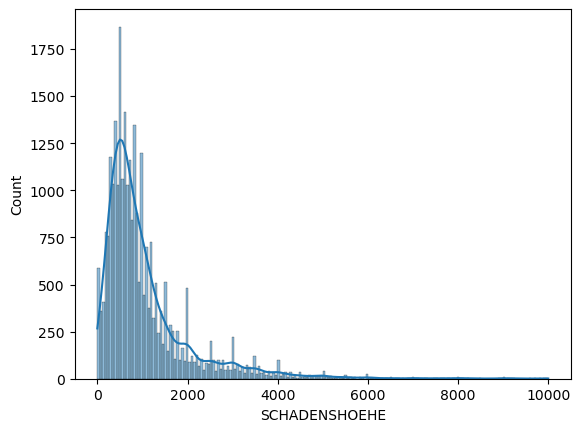

In [42]:
sns.histplot(df['SCHADENSHOEHE'], kde=True)

In [43]:
df['SCHADENSHOEHE'].sum()

30374807

### What time of the year? / Seasonal trends?

In [44]:
df_22 = df[df['TATZEIT_ENDE'].dt.year == 2022]

<Axes: xlabel='week'>

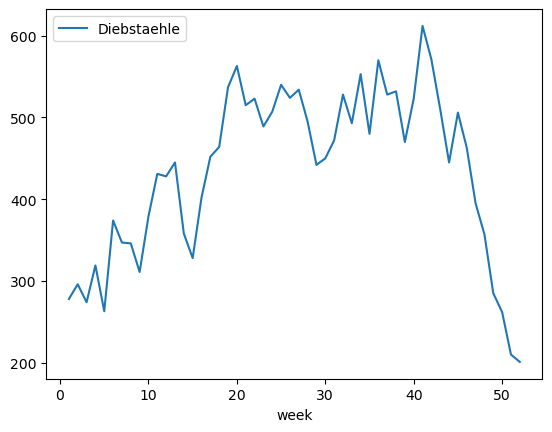

In [45]:
count_per_kw = (
    df.groupby(by=df_22["TATZEIT_ANFANG"].dt.isocalendar().week)
    .size()
    .to_frame()
    .rename(columns={0: "Diebstaehle"})
)

count_per_kw.index = count_per_kw.index.astype(int)
sns.lineplot(count_per_kw)


### What daytime?

Text(0.5, 0, 'TATZEIT_ENDE - TATZEIT_ANFANG in Stunden')

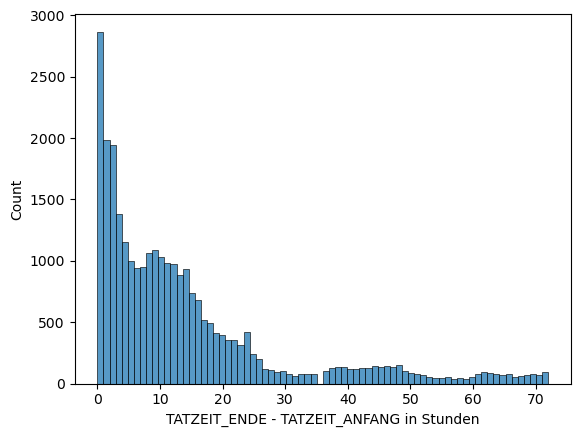

In [46]:
g = sns.histplot((df["TATZEIT_ENDE"] - df["TATZEIT_ANFANG"]) / pd.Timedelta("1 hour"))
g.set_xlabel("TATZEIT_ENDE - TATZEIT_ANFANG in Stunden")


<Axes: xlabel='TATZEIT_ANFANG'>

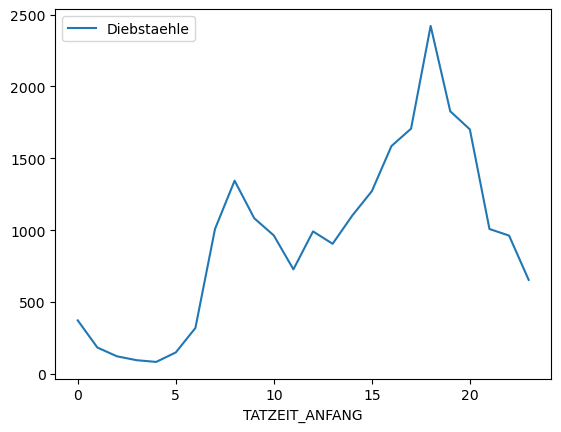

In [47]:
count_per_hour = (
    df.groupby(by=df_22["TATZEIT_ANFANG"].dt.hour)
    .size()
    .to_frame()
    .rename(columns={0: "Diebstaehle"})
)

count_per_hour.index = count_per_hour.index.astype(int)
sns.lineplot(count_per_hour)


<Axes: xlabel='TATZEIT_ENDE'>

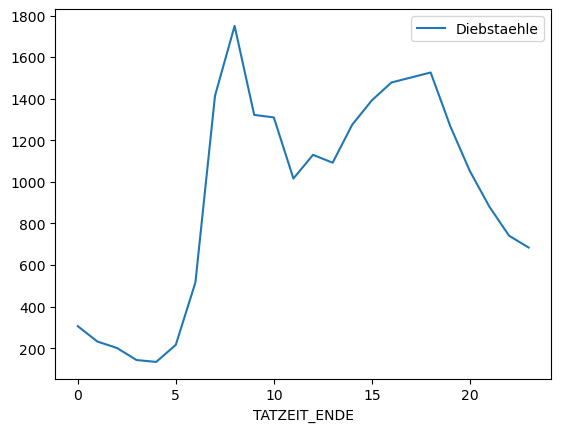

In [48]:
count_per_hour = (
    df.groupby(by=df_22["TATZEIT_ENDE"].dt.hour)
    .size()
    .to_frame()
    .rename(columns={0: "Diebstaehle"})
)

count_per_hour.index = count_per_hour.index.astype(int)
sns.lineplot(count_per_hour)
